### Deploy and Interact with LUCE contract
The aim of this notebook is to compile, deploy and interact with all functions of the improved LUCE smart contract, and then simulate three scenarios concerning cost distribution.

### Import Libraries

In [1]:
# Check which python kernel is currenlty running in this notebook
import sys
sys.executable
# For example to install the Python Web3 package
# !{sys.executable} -m pip install ipywidgets
# !jupyter nbextension enable --py widgetsnbextension
#!conda install -c conda-forge jupyterlab_widgets ipywidgets -y
#!{sys.executable} -m pip install web3 numpy pandas tqdm matplotlib altair

'/opt/conda/bin/python'

In [2]:
# Import libraries
import json
import web3

# solidity interaction
import solcx
# solcx.install_solc('v0.6.0')
from web3 import Web3
from solcx import compile_source
from web3.contract import ConciseContract

# simulation
import numpy as np
import random
import string
import pandas as pd
import time
from tqdm.notebook import tqdm
from ipywidgets import IntProgress

# visualization
import matplotlib.pyplot as plt
#import ggplot # doesn't work with newer version of pandas
import altair as alt
#import altair_saver as altsave

### Install dependencies in case it is needed 

In [3]:
#from solcx import get_installed_solc_versions, get_available_solc_versions, set_solc_version_pragma
#solcx.install_solc('v0.6.2')
#get_installed_solc_versions()
#get_available_solc_versions()
#set_solc_version_pragma('^0.6.2', check_new=True)

### Compile contract from file

In [4]:
# Read in LUCE contract code
with open('./data/new_luce.sol', 'r') as file:
    test = file.read()

# Compile & Store Compiled source code
compiled_sol = compile_source(test)

# Extract full interface as dict from compiled contract
contract_interface = compiled_sol['<stdin>:LuceMain']
register_interface = compiled_sol['<stdin>:LUCERegistry']

# Extract abi and bytecode
abi = contract_interface['abi']
bytecode = contract_interface['bin']

abi_registry = register_interface['abi']
bytecode_registry = register_interface['bin']

### Initializing the web server and accounts

In [5]:
# Use Ganache for web3 instance
w3 = Web3(Web3.HTTPProvider("http://ganache_db:8545"))

In [6]:
# Set pre-funded ganache account #0 as sender
w3.eth.defaultAccount = w3.eth.accounts[0]
dr1 = w3.eth.accounts[1]
dr2 = w3.eth.accounts[2]
accounts = w3.eth.accounts
len(accounts)

1000

### Code for distributing ether among all accounts / checking balance on all accounts

In [7]:
# Distribute Ether to all accounts
#for i in range(3,len(accounts)-1):
#    _ = w3.eth.sendTransaction({'from':accounts[2],'to':accounts[i],'value':w3.toWei(100, 'ether')})
#    print("Account balance of ",i, "is: ", w3.fromWei(w3.eth.getBalance(accounts[i]),'ether'))

The default `eth.defaultAccount` address is used as the default "from" property for transaction dictionaries if no other explicit "from" property is specified.

### Code for testing the functions of the contract

In [8]:
# # Create contract blueprint
# Luce = w3.eth.contract(abi=abi, bytecode=bytecode)
# Registry = w3.eth.contract(abi=abi_registry, bytecode=bytecode_registry)

# # Submit the transaction that deploys the contract
# tx_hash = Luce.constructor().transact()
# tx_reg = Registry.constructor().transact()

# # Wait for the transaction to be mined, and get the transaction receipt
# tx_receipt = w3.eth.waitForTransactionReceipt(tx_hash)
# reg_receipt = w3.eth.waitForTransactionReceipt(tx_reg)

# # Obtain address of freshly deployed contract
# print("Address of the contract:",tx_receipt.contractAddress)
# print("Address of the registry:", reg_receipt.contractAddress)

# # Create python instance of deployed contract
# luce1 = w3.eth.contract(
#    address=tx_receipt.contractAddress,
#    abi=contract_interface['abi'],
# )
# registry1 = w3.eth.contract(
#     address=reg_receipt.contractAddress,
#     abi=register_interface['abi']
# )

# # Publish Data
# publish_hash = luce1.functions.publishData("example description", "my link", 1).transact()

# # Connecting to Registry
# connection_hash = luce1.functions.setRegistryAddress(reg_receipt.contractAddress).transact()

# # Register new User
# reg1 = registry1.functions.registerNewUser(accounts[1],1).transact({'from': w3.eth.accounts[1]})

# # Check new User's license
# print("user's license :,"registry1.functions.checkUser(accounts[1]).call())

# # Get expected cost for next data Requester
# expected_cost = luce1.functions.expectedCosts().call({'from': w3.eth.accounts[1]})
# print("Expected cost in wei is: ",expected_cost, "wei.")

# # Register new users and update the dataset from time to time
# for i in range(31,41):
#     reg1 = registry1.functions.registerNewUser(accounts[i],1).transact({'from': w3.eth.accounts[i]})
#     expected_cost = luce1.functions.expectedCosts().call({'from': w3.eth.accounts[i]})
#     oldCost = luce1.functions.currentCost().call()
#     requester1_tx = luce1.functions.addDataRequester(1,0).transact({'from': w3.eth.accounts[i],'value': expected_cost})
#     if i%4==0:
#         newDescription = ''.join(random.choices(string.ascii_uppercase + string.digits, k = random.randint(25,150)))
#         newLink =  ''.join(random.choices(string.ascii_uppercase + string.digits, k = random.randint(5,25)))
#         temp_hash_transaction = luce1.functions.updateData(newDescription,newLink).transact()
#     newCost = luce1.functions.currentCost().call()
#     print("Old cost was:", oldCost, " new Cost is:", newCost, " requester paid:", expected_cost)

# # view the balance of the contract
# w3.eth.getBalance(tx_receipt.contractAddress)

# # Set a 'new' Licence (in this case, the same license)
# _ = luce1.functions.setlicense(1).transact()

# # Get Licence
# print('required license:',luce1.functions.getlicense().call())

# # Get the link
# print('pseudo to the data:',luce1.functions.getLink(1).call())

# # Get the data description
# print('pseudo data description is:',luce1.functions.dataDescription().call())

In [9]:
# Set random seeds
random.seed(0)
np.random.seed(0)

## Simulation Helper Functions

### Value Conversion Functions

In [10]:
# Conversion functions

def gasToDollar(gasCost):
    gasPrice = 72000000000
    etherUnit = 10**18
    dollar = 1716.52
    return gasPrice*gasCost/etherUnit*dollar

def gasToWei(gas):
    gasPrice = 72000000000
    return gasPrice*gas

def weiToDollar(wei):
    cost = float(w3.fromWei(wei,'ether'))
    return cost*1716.52

def dollarToWei(dollar):
    wei = w3.toWei(dollar/1716.52,'ether')
    return wei

### Normalization

In [11]:
def normalizeData(data):
    return (data - np.min(data)) / (np.max(data) - np.min(data))

### Data Provider Functions (Deploy, Publish, Update)

In [12]:
# Creates and deploys a new contract and publishes the corresponding dataset
def createNewDataset(d, s, address, scenario, period, div, mul, registry1, reg_receipt, providerCosts, profitMargin = 150):
    # Create contract blueprint
    d[address] = [w3.eth.contract(abi=abi, bytecode=bytecode)] # list element 0
    
    # Call constructor of the contract
    d[address].append(d[address][0].constructor().transact({'from': address})) # list element 1
    
    # Save transaction receipt
    d[address].append(w3.eth.waitForTransactionReceipt(d[address][1])) # list element 2
    
    # Create the python instance of the contract as a callable object
    d[address].append(w3.eth.contract(address=d[address][2].contractAddress, abi=contract_interface['abi'])) # list element 3
    
    # Set scenario if != 2
    if scenario != 2:
        _ = d[address][3].functions.setScenario(scenario, profitMargin).transact({'from' : address})
        if scenario == 3:
            _ = d[address][3].functions.setProfitMargin(profitMargin).transact({'from' : address})
    
    # Set cost of deployment
    price = int(round(gasToWei(d[address][2]['gasUsed'])  * d[address][3].functions.profitMargin().call({'from':address}) / 100,0))
    _ = d[address][3].functions.setPrice(price).transact({'from':address})
    
    # Set the fraction of the currentCost each data requester has to pay to receive access
    _ = d[address][3].functions.setMultis(mul,div).transact({'from':address})
    
    # Register new provider
    registration_hash = registry1.functions.newDataProvider(address).transact({'from': address})
    registration_cost = gasToDollar(w3.eth.getTransaction(registration_hash)['gas'])
    
    # Connecting to Registry
    _ = d[address][3].functions.setRegistryAddress(reg_receipt.contractAddress).transact({'from' : address})
    
    # Publish Data
    description = ''.join(random.choices(string.ascii_uppercase + string.digits, k = random.randint(25,150)))
    link =  ''.join(random.choices(string.ascii_uppercase + string.digits, k = random.randint(5,25)))
    _ = d[address][3].functions.publishData(description, link, 1).transact({'from' : address})
    
    # cost of deploying, publishing, registering first dataset
    cost = weiToDollar(d[address][3].functions.currentCost().call({'from':address}))
    providerCosts[0][len(d)-1] += cost
    
    newData = dict()
    newData['scenario'] = scenario
    newData['period'] = period
    newData['action'] = "deploy and publish"
    newData['byAddress'] = address
    newData['accountNumber'] = len(d)-1
    newData['type'] = 'provider'
    newData['contractNumber'] = len(d)-1
    newData['totalCost'] = cost + registration_cost + s.at[len(s)-1,'totalCost']
    newData['transactionCost'] = gasToDollar(d[address][2]['gasUsed']) + registration_cost
    newData['contractCost'] = cost
    newData['currentExpectedCost'] = 0
    newData['nextExpectedCost'] = cost
    newData['ProviderEarnings'] = weiToDollar(w3.eth.getBalance(d[address][2].contractAddress))
    newData['providerCost'] = providerCosts[0][len(d)-1]
    s = s.append(newData, ignore_index=True)
    
    return d, s, providerCosts
    

# update data
def updateData(sim, chosenDataProvider, chosenContract, contractReceipt, period, j, scenario, providerCosts):
    # provider updates their data
    oldCost = weiToDollar(chosenContract.functions.currentCost().call({'from':chosenDataProvider}))
    newDescription = ''.join(random.choices(string.ascii_uppercase + string.digits, k = random.randint(25,150)))
    newLink =  ''.join(random.choices(string.ascii_uppercase + string.digits, k = random.randint(5,25)))
    temp_hash_transaction = chosenContract.functions.updateData(newDescription,newLink).transact({'from':chosenDataProvider})
    newCost = weiToDollar(chosenContract.functions.currentCost().call({'from':chosenDataProvider}))
    providerCosts[0][j] += gasToDollar(w3.eth.getTransaction(temp_hash_transaction)['gas'])
    newData = dict()
    newData['scenario'] = scenario
    newData['period'] = period
    newData['action'] = "update"
    newData['byAddress'] = chosenDataProvider
    newData['accountNumber'] = j
    newData['type'] = 'provider'
    newData['contractNumber'] = j
    newData['totalCost'] = gasToDollar(w3.eth.getTransaction(temp_hash_transaction)['gas']) + sim.at[len(sim)-1,'totalCost']
    newData['transactionCost'] = gasToDollar(w3.eth.getTransaction(temp_hash_transaction)['gas'])
    newData['contractCost'] = weiToDollar(chosenContract.functions.currentCost().call({'from':chosenDataProvider}))
    newData['currentExpectedCost'] = oldCost
    newData['nextExpectedCost'] = newCost
    newData['ProviderEarnings'] = weiToDollar(w3.eth.getBalance(contractReceipt.contractAddress))
    newData['providerCost'] = providerCosts[0][j]
    sim = sim.append(newData, ignore_index=True)
    return sim, providerCosts

### Experimental Dynamic Price Adjustment Function
This function is not completely functional yet...

In [13]:
def adjustPricing(d, s):
    for provider in d:
        temp = s['currentExpectedCost']
        p35 = np.percentile(temp,35)
        p60 = np.percentile(temp,60)
        p85 = np.percentile(temp,85)
        contract = d[provider][3]
        currentCost = weiToDollar(contract.functions.currentCost().call({'from':provider}))
        if currentCost < p35:
            currentDiv = contract.functions.costDiv().call({'from':provider})
            if currentDiv != 3:
                _ = contract.functions.setMultis(1,3).transact({'from':provider})
        elif currentCost >= p35 and currentCost < p60:
            currentDiv = contract.functions.costDiv().call({'from':provider})
            if currentDiv != 6:
                _ = contract.functions.setMultis(1,6).transact({'from':provider})
        elif currentCost >= p60 and currentCost < p85:
            currentDiv = contract.functions.costDiv().call({'from':provider})
            if currentDiv != 10:
                _ = contract.functions.setMultis(1,10).transact({'from':provider})
        else:
            currentDiv = contract.functions.costDiv().call({'from':provider})
            if currentDiv != 15:
                _ = contract.functions.setMultis(1,15).transact({'from':provider})

#### Test to see how dynamic pricing develops

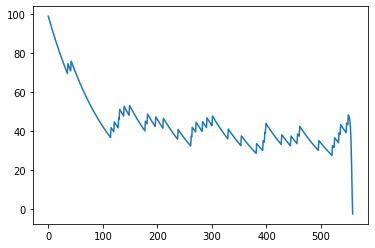

In [14]:
cost = 100
costs = []
costtemp = cost
costdelta = costtemp - cost
priceMult = 0.01
prices = []
addcost = 5
addchance = 0.05
while cost > 0:
    prices.append(priceMult*cost)
    cost = cost - cost*priceMult
    if cost*priceMult >= np.mean(prices):
        priceMult = priceMult * 2
    else:
        if priceMult/(1+priceMult) < 0.01:
            priceMult = 0.01
        else:
            priceMult = priceMult / 2
    costs.append(cost)
    if random.uniform(0,1) < addchance:
        cost += 5
        costs.append(cost)
plt.plot(costs)
plt.show()

### Data Requester Functions (Request, Renew)

In [15]:
# new requester
def addRequester(sim, requesterAddress, provider, contractReceipt, contract, requesterNumber, ls, period, scenario, registry1, accessTimePeriod):
    # Check is requester is registered
    notYetRegistered = registry1.functions.checkUser(requesterAddress).call() == 0
    if notYetRegistered:
        # Register new user
        registration_hash = registry1.functions.registerNewUser(requesterAddress,1).transact({'from': requesterAddress})
        registration_cost = gasToDollar(w3.eth.getTransaction(registration_hash)['gas'])
    
    # Check whether the requester already has a token
    hasNoToken = True
    try:
        hasNoToken = contract.functions.getTokenId(requesterAddress).call({'from': requesterAddress}) > 0
        hasNoToken = False
    except:
        pass
    if hasNoToken:
        oldCost = contract.functions.expectedCosts().call({'from': requesterAddress})
        # Request access to data by current requester
        temp_hash_transaction = contract.functions.addDataRequester(1,accessTimePeriod).transact({'from': requesterAddress, 'value': oldCost})
        
        ls.append([requesterAddress, contract, provider, requesterNumber, contractReceipt])
        newData = dict()
        newData['scenario'] = scenario
        newData['period'] = period
        newData['action'] = "addDataRequester"
        newData['byAddress'] = requesterAddress
        newData['accountNumber'] = requesterNumber
        newData['type'] = 'requester'
        newData['contractNumber'] = provider
        newData['totalCost'] = gasToDollar(w3.eth.getTransaction(temp_hash_transaction)['gas']) + sim.at[len(sim)-1,'totalCost']
        newData['transactionCost'] = gasToDollar(w3.eth.getTransaction(temp_hash_transaction)['gas']) + weiToDollar(oldCost)
        newData['contractCost'] = weiToDollar(contract.functions.currentCost().call({'from':requesterAddress}))
        newData['currentExpectedCost'] = weiToDollar(oldCost)
        newData['nextExpectedCost'] = weiToDollar(contract.functions.expectedCosts().call({'from': requesterAddress}))
        newData['ProviderEarnings'] = weiToDollar(w3.eth.getBalance(contractReceipt.contractAddress))
        newData['providerCost'] = 0
        sim = sim.append(newData, ignore_index=True)
            
        if requesterNumber == 999:
            requesterNumber = 10
        else:
            requesterNumber += 1
        s = True
    return sim, s, ls, requesterNumber


# renewAccess
def renewAccess(user, p, s, c, t, scenario):
    success = False
    currentRequester = user[0]
    chosenContract = user[1]
    provider = user[2]
    requesterNumber = user[3]
    contractReceipt = user[4]
    tokenId = chosenContract.functions.getTokenId(currentRequester).call({'from' : currentRequester})
    accessOver = time.time() > chosenContract.functions.getAccessTime(tokenId).call({'from' : currentRequester})
    #accessOver = True
    compliance = chosenContract.functions.getCompliance(currentRequester).call({'from' : currentRequester})
    compliance_cost = 0
    if compliance == False: 
        compliance_hash = chosenContract.functions.confirmCompliance().transact({'from' : currentRequester})
        compliance_cost = weiToDollar(w3.eth.getTransaction(compliance_hash)['gas'])
    if accessOver:
        # Renew existing user's token access time
        oldCost = chosenContract.functions.expectedCosts().call({'from': currentRequester})
        temp_hash_transaction = chosenContract.functions.renewToken(t).transact({'from': currentRequester, 'value': oldCost})
        renewal_cost = gasToDollar(w3.eth.getTransaction(temp_hash_transaction)['gas'])
        newData = dict()
        newData['scenario'] = scenario
        newData['period'] = c
        newData['action'] = 'renewToken'
        newData['byAddress'] = currentRequester
        newData['accountNumber'] = requesterNumber
        newData['type'] = 'requester'
        newData['contractNumber'] = provider
        newData['totalCost'] = gasToDollar(w3.eth.getTransaction(temp_hash_transaction)['gas']) + s.at[len(s)-1,'totalCost']
        newData['transactionCost'] = renewal_cost + weiToDollar(oldCost) + compliance_cost
        newData['contractCost'] = weiToDollar(chosenContract.functions.currentCost().call({'from': currentRequester}))
        newData['currentExpectedCost'] = weiToDollar(oldCost)
        newData['nextExpectedCost'] = weiToDollar(chosenContract.functions.expectedCosts().call({'from' : currentRequester}))
        newData['ProviderEarnings'] = weiToDollar(w3.eth.getBalance(contractReceipt.contractAddress))
        newData['providerCost'] = 0
        s = s.append(newData, ignore_index=True)
        success = True
    return(s, success)

### Registry Deployment Function

In [16]:
def newRegistry():
    # Creating the registry:
    Registry = w3.eth.contract(abi=abi_registry, bytecode=bytecode_registry)
    tx_reg = Registry.constructor().transact()
    reg_receipt = w3.eth.waitForTransactionReceipt(tx_reg)
    # print(reg_receipt.contractAddress)
    registry1 = w3.eth.contract(
        address=reg_receipt.contractAddress,
        abi=register_interface['abi']
    )
    return registry1, reg_receipt

## Main Simulation Function

In [17]:
def simulate(actionTicker, costDiv,costMult, 
             mu=0, sigma=0.1, interval=0.01, scenario = 2, 
             accessTimePeriod=30, providerProbabilities=0.05, 
             updateMult=3, maxDataProviders=10, dynamicPricing=False, 
             profitMargins = [110,120,130,140,150,160,170,180,190,200]):
    # dataframe to keep track of the 'people' in our simulation, each with a probability to take action 
    # based on a normal distribution specified by mu and sigma
    d = pd.DataFrame(accounts,columns=['Addresses'])
    f = pd.DataFrame(np.zeros((len(accounts),3)), columns=['accumulatedCost','numberOfRequests','probability'])
    df = pd.concat([d,f], axis=1, sort=False)
    x = np.random.normal(mu, sigma, len(accounts))
    np.random.shuffle(x)
    df[['probability']] = normalizeData(x)
    df.loc[(df.probability < 0.01),'probability']=0.01
    for k in range(0,maxDataProviders):
        df.loc[k, 'probability'] = providerProbabilities #random.uniform(0,providerProbabilities)
    
    # time representation
    period = 0
    
    # initializing the first dataProvider
    # Initializing dictionary of all contracts with published datasets
    d = dict()
    count = 0
    
    # dataframe to keep track of the simulation
    sim = pd.DataFrame(np.zeros((1,14)), columns=['scenario','period','action','byAddress', 'accountNumber','type',
                                                  'contractNumber','totalCost','transactionCost','contractCost',
                                                  'currentExpectedCost','nextExpectedCost','ProviderEarnings','providerCost'])
    
    # create new registry to reset simulation stuff
    registry1, reg_receipt = newRegistry()
    
    
    # in case of scenario 3:
    m = 0
    nextProfitMargin = profitMargins[m]
    providerCosts = np.zeros((1,maxDataProviders))
    
    # accounts[0] is the first data provider
    # createNewDataset(d, s, address, scenario, period, div, mul, registry1, profitMargin = 150):
    d, sim, providerCosts = createNewDataset(d, sim, df.at[0,'Addresses'], scenario, period, 
                              costDiv,costMult,registry1,reg_receipt,providerCosts,profitMargin=nextProfitMargin)
    m += 1
    
    provider = [0] # ranging from 0 to 9
    latestProvider = 0
    requester = maxDataProviders # ranging from 10 to 999
    requesterList = []
    i = 0
    pbar = tqdm(total=actionTicker)
    standard_time = accessTimePeriod / 2
    while i < actionTicker:
        
        start_time = time.time()
        
        period += 1
        
        
        p = random.uniform(0,1)
        
        # will a new data provider publish their dataset?
        if latestProvider < maxDataProviders-1 and p < df.at[latestProvider,'probability']:
            latestProvider += 1
            addressOfProvider = df.at[latestProvider,'Addresses']
            # createNewDataset(d, s, address, scenario, period, div, mul, registry1, profitMargin = 150):
            d, sim, providerCosts = createNewDataset(d, sim, addressOfProvider, scenario, period, 
                                      costDiv, costMult, registry1, reg_receipt, providerCosts, profitMargin = profitMargins[m])
            m += 1
            provider.append(latestProvider)
            i += 1
            #print("period: ", period, "Provider: ", latestProvider, " deploys and publishes; p is",p, " vs ", df.at[latestProvider,'probability'])
            pbar.update(1)
            
        
        
        # loop through all dataProviders to see if any update in this period
        for j in range(0,len(provider)):
            #print(p, "vs", df.at[provider[j],'probability']*updateMult)
            p = random.uniform(0,1)
            if p < df.at[provider[j],'probability']*updateMult:
                chosenDataProvider = df.at[provider[j],'Addresses']
                chosenContract = d[chosenDataProvider][3]
                chosenContractReceipt = d[df.at[provider[j],'Addresses']][2]
                # updateData(sim, chosenDataProvider, chosenContract, period, j, scenario)
                sim, providerCosts = updateData(sim, chosenDataProvider, chosenContract, chosenContractReceipt, period, j, scenario,providerCosts)
                i += 1
                #print("period: ", period, "Provider: ", j, " updates; p is",p, " vs ", df.at[provider[j],'probability'])
                pbar.update(1)
        
        r = random.uniform(0,1)
        
        # will this data requester access the datasets?
        if r < df.at[requester,'probability']:
            success = False
            currentRequester = df.at[requester,'Addresses']
            chosenProviderNumber = provider[random.randint(0,len(provider)-1)]
            chosenContractReceipt = d[df.at[chosenProviderNumber,'Addresses']][2]
            chosenContract = d[df.at[chosenProviderNumber,'Addresses']][3]
            sim, success, requesterList, requester = addRequester(sim, currentRequester, chosenProviderNumber,
                                                                  chosenContractReceipt, chosenContract, requester, 
                                                                  requesterList, period, scenario, registry1, 
                                                                  accessTimePeriod)
            if success:
                pbar.update(1)
                #print("period: ", period, "Requester: ", requester, " requests; p is",p, " vs ", df.at[requester,'probability'])
                i += 1
        
        
        # Requester renews?
        if len(requesterList)>3:
            for req in requesterList:
                r = random.uniform(0,1)
                if r < df.at[req[3],'probability']:
                    success = False
                    sim, success = renewAccess(req, p, sim, period, accessTimePeriod, scenario)
                    if success:
                        i += 1
                        df.loc[req[3], 'probability'] = df.loc[req[3], 'probability'] * 0.75
                        #print("period: ", period, "Requester: ", req[3], " renews; p is",p, " vs ", df.at[req[3],'probability'])
                        pbar.update(1)
        
        
        # Adjust dynamic pricing:
        if dynamicPricing:
            adjustPricing(d,sim)
        
        elapsed_time = time.time() - start_time
        if standard_time > elapsed_time:
            time.sleep(standard_time - elapsed_time)
            
    return sim, df, d

### Quick Overview Creation

In [18]:
def graphmaker(df):
    testframe = df[df['contractNumber'] == 0]
    g = alt.Chart(testframe[testframe['type'] == 'requester']).encode(x='period')
    g = alt.layer(
        g.mark_line(color='blue').encode(y='contractCost'),
        g.mark_line(color='red').encode(y='currentExpectedCost'),
        g.mark_line(color='orange').encode(y='transactionCost')
    )
    return g

## Simulation Templates

In [ ]:
# # def simulate(actionTicker, costDiv,costMult, 
# #              mu=0, sigma=0.1, interval=0.01, scenario = 2, 
# #              accessTimePeriod=30, providerProbabilities=0.05, 
# #              updateMult=3, maxDataProviders=10, dynamicPricing=False):
# s02, a02, _ = simulate(5,5,1,accessTimePeriod=30,updateMult=3,maxDataProviders=1)
# provideractions = len(s02[s02['type']=='provider'])
# requesteractions= len(s02[s02['type']=='requester'])
# print("ProviderActions:", provideractions, "-- RequesterActions:", requesteractions)

In [ ]:
# g02_1000 = graphmaker(s02)
# g02_1000

In [21]:
# # def simulate(actionTicker, costDiv,costMult, 
# #              mu=0, sigma=0.1, interval=0.01, scenario = 2, 
# #              accessTimePeriod=30, providerProbabilities=0.05, 
# #              updateMult=3, maxDataProviders=10, dynamicPricing=False):
# s02, a02, _ = simulate(5,5,1,accessTimePeriod=30,updateMult=3,maxDataProviders=1)
# provideractions = len(s02[s02['type']=='provider'])
# requesteractions= len(s02[s02['type']=='requester'])
# print("ProviderActions:", provideractions, "-- RequesterActions:", requesteractions)

In [22]:
#g02_1000 = graphmaker(s02)
#g02_1000

In [23]:
# # def simulate(actionTicker, costDiv,costMult, 
# #              mu=0, sigma=0.1, interval=0.01, scenario = 2, 
# #              accessTimePeriod=30, providerProbabilities=0.05, 
# #              updateMult=3, maxDataProviders=10, dynamicPricing=False):
# s02, a02, _ = simulate(150,5,1,accessTimePeriod=30,updateMult=3,maxDataProviders=1)
# provideractions = len(s02[s02['type']=='provider'])
# requesteractions= len(s02[s02['type']=='requester'])
# print("ProviderActions:", provideractions, "-- RequesterActions:", requesteractions)

In [24]:
# g02_1000 = graphmaker(s02)
# g02_1000

In [25]:
# # def simulate(actionTicker, costDiv,costMult, 
# #              mu=0, sigma=0.1, interval=0.01, scenario = 2, 
# #              accessTimePeriod=30, providerProbabilities=0.05, 
# #              updateMult=3, maxDataProviders=10, dynamicPricing=False):
# s02, a02, _ = simulate(150,5,1,accessTimePeriod=30,updateMult=3,maxDataProviders=1)
# provideractions = len(s02[s02['type']=='provider'])
# requesteractions= len(s02[s02['type']=='requester'])
# print("ProviderActions:", provideractions, "-- RequesterActions:", requesteractions)

In [26]:
# g02_1000 = graphmaker(s02)
# g02_1000

In [27]:
# # def simulate(actionTicker, costDiv,costMult, 
# #              mu=0, sigma=0.1, interval=0.01, scenario = 2, 
# #              accessTimePeriod=30, providerProbabilities=0.05, 
# #              updateMult=3, maxDataProviders=10, dynamicPricing=False):
# s02, a02, _ = simulate(150,5,1,accessTimePeriod=30,updateMult=3,maxDataProviders=1)
# provideractions = len(s02[s02['type']=='provider'])
# requesteractions= len(s02[s02['type']=='requester'])
# print("ProviderActions:", provideractions, "-- RequesterActions:", requesteractions)

In [28]:
# g02_1000 = graphmaker(s02)
# g02_1000

### Functions to conveniently run multiple scenarios

In [29]:
# def simulate(actionTicker, costDiv,costMult, 
#              mu=0, sigma=0.1, interval=0.01, scenario = 2, 
#              accessTimePeriod=30, providerProbabilities=0.05, 
#              updateMult=3, maxDataProviders=10, dynamicPricing=False):

def scenarios(actions,div,mul):
    s1, _, _ = simulate(actions,div,mul, scenario = 1,accessTimePeriod=30,updateMult=3,maxDataProviders=1)
    s2, _, _ = simulate(actions,div,mul, scenario = 2,accessTimePeriod=30,updateMult=3,maxDataProviders=1)
    s3, _, _ = simulate(actions,div,mul, scenario = 3,accessTimePeriod=30,updateMult=3,maxDataProviders=1, profitMargins=[200])
    s = s1.append(s2)
    s = s.append(s3)
    return s

In [30]:
def testMultipliers(iterations, divs, mults):
    data = []
    for i in range(0,len(divs)):
        s = scenarios(iterations, divs[i], mults[i])
        fraction = round(mults[i]/divs[i],2)
        s = s.drop([0])
        s['fraction'] = fraction
        data.append(s)
    x = data[0]
    for i in range(1,len(data)):
        x = x.append(data[i], ignore_index=True)
    return x

## Simulation

First we initialize some values for easy adaption for the simulations afterwards

In [31]:
ds1 = [20,10,100]
ms1 = [1,1,1]
actions = 500
accessTime = 10
datasets = []

In [33]:
# s100, _, _ = simulate(actions,ds1[0],ms1[0], scenario = 1,accessTimePeriod=accessTime,updateMult=5,maxDataProviders=1)
# fraction = round(ms1[0]/ds1[0],2)
# s100 = s100.drop([0])
# s100['fraction'] = fraction
# s100.to_csv('scenario110.csv', index = True)
datasets.append('scenario110.csv')

In [34]:
# s200, _, _ = simulate(actions,ds1[0],ms1[0], scenario = 2,accessTimePeriod=accessTime,updateMult=5,maxDataProviders=1)
# fraction = round(ms1[0]/ds1[0],2)
# s200 = s200.drop([0])
# s200['fraction'] = fraction
# s200.to_csv('scenario210.csv', index = True)
datasets.append('scenario210.csv')

In [35]:
# s201, _, _ = simulate(actions,ds1[1],ms1[1], scenario = 2,accessTimePeriod=accessTime,updateMult=5,maxDataProviders=1)
# fraction = round(ms1[1]/ds1[1],2)
# s201 = s201.drop([0])
# s201['fraction'] = fraction
# s201.to_csv('scenario201.csv', index = True)
# # datasets.append('scenario100.csv')
datasets.append('scenario201.csv')
 # datasets.append('scenario301.csv')

In [36]:
# s202, _, _ = simulate(actions,ds1[2],ms1[2], scenario = 2,accessTimePeriod=accessTime,updateMult=5,maxDataProviders=1)
# fraction = round(ms1[2]/ds1[2],2)
# s202 = s202.drop([0])
# s202['fraction'] = fraction
# s202.to_csv('scenario202.csv', index = True)
datasets.append('scenario202.csv')

In [37]:
# s300, _, _ = simulate(actions,ds1[0],ms1[0], scenario = 3,accessTimePeriod=30,updateMult=5,maxDataProviders=1, profitMargins=[200])
# fraction = round(ms1[0]/ds1[0],2)
# s300 = s300.drop([0])
# s300['fraction'] = fraction
# s300.to_csv('scenario310.csv', index = True)
datasets.append('scenario310.csv')

In [38]:
# s301, _, _ = simulate(actions,ds1[1],ms1[1], scenario = 3,accessTimePeriod=accessTime,updateMult=5,maxDataProviders=1, profitMargins=[200])
# fraction = round(ms1[1]/ds1[1],2)
# s301 = s301.drop([0])
# s301['fraction'] = fraction
# s301.to_csv('scenario301.csv', index = True)
datasets.append('scenario301.csv')

In [39]:
# s302, _, _ = simulate(actions,ds1[2],ms1[2], scenario = 3,accessTimePeriod=30,updateMult=5,maxDataProviders=1, profitMargins=[200])
# fraction = round(ms1[2]/ds1[2],2)
# s302 = s302.drop([0])
# s302['fraction'] = fraction
# s302.to_csv('scenario302.csv', index = True)
datasets.append('scenario302.csv')

### Compile simulation results into one dataset

In [40]:
s = pd.read_csv(datasets[0])
for i in range(1,len(datasets)):
    s = s.append(pd.read_csv(datasets[i]))
s = s.drop(['Unnamed: 0'], axis=1)
s.to_csv('2020-07-28-15-13-simulation.csv', index = True)

In [41]:
s = pd.read_csv('2020-07-28-15-13-simulation.csv')
s = s.drop(['Unnamed: 0'], axis = 1)
s['Cost'] = s[['transactionCost']]
s['Cost type'] = 'Base cost'
len(s)
t = s.copy()
t['Cost'] = s[['currentExpectedCost']]
t['Cost type'] = 'Additional cost'
st = s.append(t, ignore_index=True)
st.to_csv('2020-07-28-15-13-simulation.csv')


In [42]:
pc = 0
for k in range(0,len(st)):
    pcn = st.loc[k, 'providerCost']
    if pcn == 0:
        st.loc[k, 'providerCost'] = pc
    else: 
        pc = st.loc[k, 'providerCost']
        
# st[['ProviderEarnings','providerCost']].head()
# st[st['scenario']==2].head(25)

In [43]:
st.to_csv('2020-07-28-15-13-simulation.csv')

In [44]:
# s = pd.read_csv('2020-07-27-20-05-simulation.csv')
# for i in range(1,len(datasets)):
#     s = s.append(pd.read_csv(datasets[i]))
# s = s.drop(['Unnamed: 0'], axis=1)
# s.to_csv('2020-07-27-20-42-simulation.csv', index = True)

### Additional simulations

In [45]:
ds1 = [2,10,100]
ms1 = [1,1,1]
actions = [50,500,1000]
# ds1 = [2]
# ds1 = [1]
# actions = [50]
datasets = []

In [ ]:
sets = []
for i in range(0,len(actions)):
    for j in range(0, len(ds1)):
        s2, _, _ = simulate(actions[i],ds1[j],ms1[j], scenario = 2,accessTimePeriod=30,maxDataProviders=1)
        fraction = round(ms1[j] / ds1[j],2)
        s2['fraction'] = round(ms1[j] / ds1[j],2)
        filename = ''.join('2020-07-29-'+str(actions[i])+'-'+str(int(fraction*100))+'.csv')
        print(filename)
        s2.to_csv(filename, index=True)
        s2 = pd.read_csv(filename)
        s2 = s2.drop(['Unnamed: 0'], axis=1)
        s2 = s2.drop([0], axis = 0)
        s2['actionNum'] = actions[i]
        #s3 = s3.drop(['fraction'], axis=1)
        a = np.mean(s2[['actionNum']])
        f = np.mean(s2[['fraction']])
        print(int(a),int(f*100))
        sets.append(s2)


In [47]:
s = sets[0]
for i in range(1,len(sets)):
    s = s.append(sets[i], ignore_index=True)
    
s.to_csv('2020-07-28-19-21-simulation.csv', index = True)

In [48]:
s = pd.read_csv('2020-07-28-19-21-simulation.csv')
s = s.drop(['Unnamed: 0'], axis=1)

### Initial Visualization

In [49]:
charts = []
for i in range(0,len(ds1)):
    t1 = s[s['fraction'] == ms1[i]/ds1[i]]
    charts.append(alt.Chart(t1).mark_line().encode(
        x='period',
        y='contractCost',
    ).properties(
        width=180,
        height=180
    ).facet(
        facet='actionNum',
        columns=3
    ))

In [50]:
charts = []
for i in range(0,len(ds1)):
    t1 = s[s['fraction'] == ms1[i]/ds1[i]]
    charts.append(alt.Chart(t1).mark_line().encode(
        x='period',
        y='contractCost',
    ).properties(
        width=180,
        height=180
    ))

In [51]:
charts[0]

alt.Chart(...)

In [52]:
charts[1]

alt.Chart(...)

In [53]:
charts[2]

alt.Chart(...)